In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from bcg_code import *

from IPython.display import clear_output

In [2]:
experiments = []


Λ = np.load('matrices/outliers20.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

l = 20
experiments.append({'name':'outliers20', 'Λ':Λ, 'b':b, 'ts':np.arange(76,dtype='int'), 'reorth':True, 'l':l, 'μs':[0]})


Λ = np.load('matrices/nos7.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

l = 1
experiments.append({'name':'nos7', 'Λ':Λ, 'b':b, 'ts':np.arange(250,dtype='int'), 'reorth':True, 'l':l, 'μs':[0]})


Λ = np.load('matrices/raefsky4.npy')+1
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

l = 10
experiments.append({'name':'raefsky4', 'Λ':Λ, 'b':b, 'ts':np.arange(250,dtype='int'), 'reorth':True, 'l':l, 'μs':[0]})


Λ = np.load('matrices/outliers20.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

l = 22
experiments.append({'name':'outliers20', 'Λ':Λ, 'b':b, 'ts':np.arange(76,dtype='int'), 'reorth':True, 'l':l, 'μs':[0]})


Λ = np.load('matrices/model.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

l = 4
experiments.append({'name':'model', 'Λ':Λ, 'b':b, 'ts':np.arange(18,dtype='int'), 'reorth':True, 'l':l, 'μs':[0]})


Λ = np.load('matrices/bcsstm25.npy')+1
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

l = 100
experiments.append({'name':'bcsstm25', 'Λ':Λ, 'b':b, 'ts':np.arange(126,dtype='int'), 'reorth':True, 'l':l, 'μs':[0]})


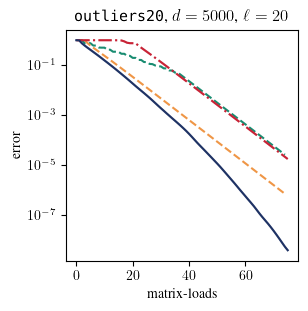

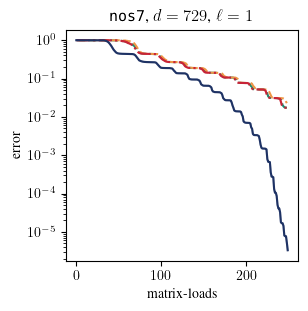

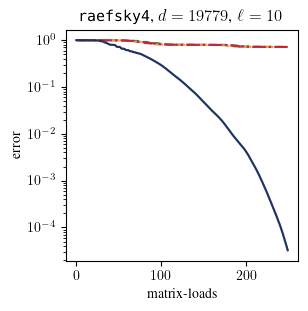

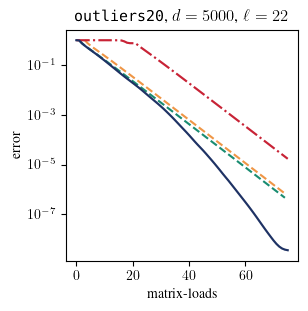

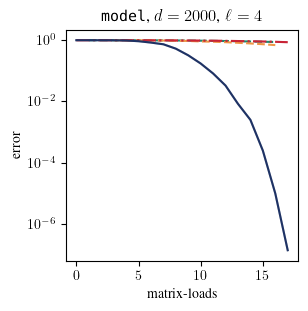

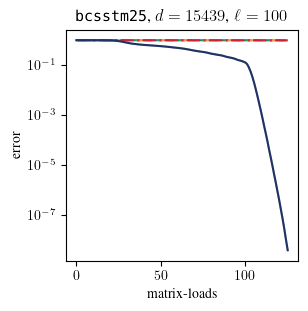

In [3]:
for experiment in experiments:

    name = experiment['name']
    Λ = experiment['Λ']
    b = experiment['b']
    ts = experiment['ts']
    reorth = experiment['reorth']
    l = experiment['l']
    μs = experiment['μs']

    d = len(Λ)
    A = sp.sparse.spdiags(Λ.reshape(1,d),[0])
    x_true = np.diag(1/Λ)@b

    μ = μs[0]
    x_true = (1/(Λ+μ))*b

    ss = [1,3]
    
    # CG
    x_CG = get_BCG_sols(A,b.reshape(d,1),ts,μs,reorth=reorth)
    err_CG = np.full(len(ts),np.nan)
    for i,t in enumerate(ts):
        e = x_true-x_CG[i,0]
        err_CG[i] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)

    if reorth==False:
        reorth_max = l*max(ss)
        
        x_CG_pro = get_BCG_sols(A,b.reshape(d,1),ts,μs,reorth=True,reorth_max=reorth_max)
        err_CG_pro = np.full(len(ts),np.nan)
        for i,t in enumerate(ts):
            e = x_true-x_CG_pro[i,0]
            err_CG_pro[i] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)


    # nystrom PCG
    np.random.seed(0)
    Ω = np.random.randn(d,l)

    err_PCG = np.full((len(ts),len(ss)),np.nan)
    for si,s in enumerate(ss):
        U,D = nystrom(A,Ω,s)
    
        Aμ = A + μ*sp.sparse.eye(d)
        Pμ = deflation_precond12(U,D,D[-1],μ)
    
        x_PCG = get_PCG_sols(Aμ,b.reshape(d,1),Pμ,ts,reorth=reorth)
        for i,t in enumerate(ts):
            e = x_true-x_PCG[i]
            err_PCG[i,si] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)

        
    # block CG
    B = np.hstack([b.reshape(d,1),Ω])

    x_BCG = get_BCG_sols(A,B,ts,μs,reorth=reorth)
    err_BCG = np.full(len(ts),np.nan)
    for i,t in enumerate(ts):
        e = x_true-x_BCG[i,0]
        err_BCG[i] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)

    if reorth==False:
        reorth_max = max(ss)

        x_BCG_pro = get_BCG_sols(A,B,ts,μs,reorth=True,reorth_max=reorth_max)
        err_BCG_pro = np.full(len(ts),np.nan)
        for i,t in enumerate(ts):
            e = x_true-x_BCG_pro[i,0]
            err_BCG_pro[i] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)


    fig,ax = plt.subplots(1,1,figsize=(3,3))

    if reorth:
        si=0; s = ss[si]
        mask = ts <= max(ts)-s-1
        plt.plot(ts[mask]+s,err_PCG[mask,si],ls='--',color=c3,label=f'PCG ($s={s}$)')
    
    si=1; s = ss[si]
    mask = ts <= max(ts)-s-1
    plt.plot(ts[mask]+s,err_PCG[mask,si],ls='--',color=c4,label=f'PCG ($s={s}$)')

    plt.plot(ts,err_CG,ls='-.',color=c2,label='CG',alpha=.25)
    plt.plot(ts,err_BCG,ls='-',color=c1,label='BCG',alpha=.25)

    if reorth:
        plt.plot(ts,err_CG,ls='-.',color=c2,label='CG')
        plt.plot(ts,err_BCG,ls='-',color=c1,label='BCG')
    else:
        plt.plot(ts,err_CG,ls='-.',color=c2,label='CG',alpha=.25)
        plt.plot(ts,err_BCG,ls='-',color=c1,label='BCG',alpha=.25)
        plt.plot(ts,err_CG_pro,ls='-.',color=c2,label='CG')
        plt.plot(ts,err_BCG_pro,ls='-',color=c1,label='BCG')

    # plt.plot(2*np.exp(-2*np.arange(t)/(np.sqrt(Λ[0]/Λ[-1]))),ls=':',color='k')

    plt.title(f'\\texttt{{{name}}}, $d={d}$, $\ell = {l}$')
    plt.ylabel('error')
    plt.xlabel(f'matrix-loads')
    
    plt.yscale('log')

    plt.savefig(f"imgs/iter_error_{name}_l{l}{'' if reorth else '_fp'}.pdf",bbox_inches='tight')

    # plt.close()